In [ ]:
import os
import pydicom
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

MAIN_FOLDER_PATH = "/data/tciabreastdata"
OUTPUT_FILE = "raw_data.parquet"
SUBSET_SIZE = None
MAX_WORKERS = multiprocessing.cpu_count()

TAGS_TO_EXTRACT = {
    "patient_id": (0x0010, 0x0020),
    "study_instance_uid": (0x0020, 0x000D),
    "series_instance_uid": (0x0020, 0x000E),
    "series_number": (0x0020, 0x0011),
    "series_time": (0x0008, 0x0031),
    "modality": (0x0008, 0x0060),
    "series_description": (0x0008, 0x103E),
    "image_type": (0x0008, 0x0008),
    "study_date": (0x0008, 0x0020),
    "instance_number": (0x0020, 0x0013),
    "acquisition_time": (0x0008, 0x0032),
    "repetition_time": (0x0018, 0x0080),
    "echo_time": (0x0018, 0x0081),
    "contrast_bolus_agent": (0x0018, 0x0010),
    "NumberOfTemporalPositions": (0x0020, 0x0105),
    "TemporalPositionIdentifier": (0x0020, 0x0100),
    "Manufacturer": (0x0008, 0x0070),
    "Nb_image_in_one_serie_GE": (0x0025, 0x1007),
    "media_store": (0x0002, 0x0003),
    "manufacturer_model": (0x0008, 0x1090),
    "DCE_tot_GE": (0x0020, 0x1002),
    "Breast_R_L": (0x0018, 0x1250),
    "image_position" : (0x0020,0x0032),
    "image_orientation" : (0x0020,0x0037),
    "Acquisition_Matrix" : (0x0018,0x1310),
    "Rows" : (0x0028 , 0x0010),
    "Columns" : (0x0028 , 0x0010),
    "Pixel_pacing" : (0x0028,0x0030),
    "slice_thickness" : (0x0018,0x0050)
}

BREAST_ALTERNATIVE_TAG = (0x0010, 0x21B0)

def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def get_dicom_files_generator(root_dir, limit=None):
    count = 0
    for root, _, files in os.walk(root_dir):
        for filename in files:
            if filename.endswith(".dcm"):
                yield os.path.join(root, filename)
                count += 1
                if limit and count >= limit:
                    return


def extract_dicom_metadata(file_path):
    try:
        dcm_data = pydicom.dcmread(file_path, stop_before_pixels=True, force=True)
        metadata = {"file_path": file_path}

        for name, tag in TAGS_TO_EXTRACT.items():
            element = dcm_data.get(tag)
            if element and element.value is not None:
                value = element.value
                if isinstance(value, pydicom.multival.MultiValue):
                    metadata[name] = ";".join(map(str, value))
                else:
                    metadata[name] = str(value)
            else:
                metadata[name] = None

        if metadata.get("Breast_R_L") == "EXTREM":
            alternative_element = dcm_data.get(BREAST_ALTERNATIVE_TAG)
            if alternative_element and alternative_element.value is not None:
                value = alternative_element.value
                if isinstance(value, pydicom.multival.MultiValue):
                    metadata["Breast_R_L"] = ";".join(map(str, value))
                else:
                    metadata["Breast_R_L"] = str(value)

        return metadata
    except Exception:
        return None


def extract_dicom_batch(file_paths):
    results = []
    for file_path in file_paths:
        metadata = extract_dicom_metadata(file_path)
        if metadata:
            results.append(metadata)
    return results


def raw_data(MAIN_FOLDER_PATH=MAIN_FOLDER_PATH, OUTPUT_FILE=OUTPUT_FILE,
             MAX_WORKERS=MAX_WORKERS, TAGS_TO_EXTRACT=TAGS_TO_EXTRACT,
             SUBSET_SIZE=SUBSET_SIZE):
    dicom_files = list(get_dicom_files_generator(MAIN_FOLDER_PATH, limit=SUBSET_SIZE))
    print(f"  → {len(dicom_files)} fichiers DICOM trouvés")

    chunk_size = max(1, len(dicom_files) // (MAX_WORKERS * 4))
    file_chunks = list(chunk_list(dicom_files, chunk_size))

    all_metadata = []
    with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(extract_dicom_batch, chunk): chunk for chunk in file_chunks}
        with tqdm(total=len(file_chunks), desc="Extraction") as pbar:
            for future in as_completed(futures):
                try:
                    all_metadata.extend(future.result())
                except Exception:
                    pass
                finally:
                    pbar.update(1)

    df = pd.DataFrame(all_metadata)
    df.to_parquet(OUTPUT_FILE)

raw_data()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
from google import genai
from google.genai import types

def categorize_breast(normalized_value):
    if normalized_value == 'R':
        return 'DCE_R'
    elif normalized_value == 'L':
        return 'DCE_L'
    elif normalized_value == 'B':
        return 'DCE_B'
    elif normalized_value == 'O':
        return 'DCE_O'
    else:
        return 'DCE_U'

# ACRIN Contralateral Breast MR

This repository explains the different stages of Data Processing aimed at detecting and regrouping all Dynamic Contrast-Enhanced (DCE) MRI features for each patient. To complete this task, I used both the metadata at my disposal in the DCM files and the clinical report provided, to make sure the patient selected has a DCE scan.

The data I have used are DICOM data, which are stored in a hierarchical way. At the top level is the Patient. Each Patient can have one or more Studies, which typically refer to a specific analysis or visit (when they went to the doctor). Each Study then contains several Series, where the actual information and images from the analysis are stored.

Inside the series, there is a lot of metadata, such as:
* The **acquisition time**
* The equipment **manufacturer**
* Image resolution and **voxel spacing**
* Patient position
* The free text **Series Description**

Missing information is usually common in the metadata because it depends on the person that created the file.

My journey began by detecting the patient DCEs inside this huge 200 GB database, because this database contains several types of MRIs.

## Laterality and Breast Location

As mentioned, missing metadata was a significant problem. For instance, another critical piece of information missing from this data is the laterality, which is important for understanding how the image was taken. We have three possible lateralities:

- AXIAL
- CORONAL
- SAGITTAL

This information was missing. The solution I devised to solve this issue was to create a method that determines the plan from which the image was taken.

We can find this information by knowing how the images are regrouped to create a volume. If the image is compiled using the z-axis, it is an Axial view; if compiled using the x-axis, it is a Sagittal view; and if compiled using the y-axis, it is a Coronal view.

This information is also critical when using machine learning models. We want all the images to be in the same plan to help the model learn information from the data.

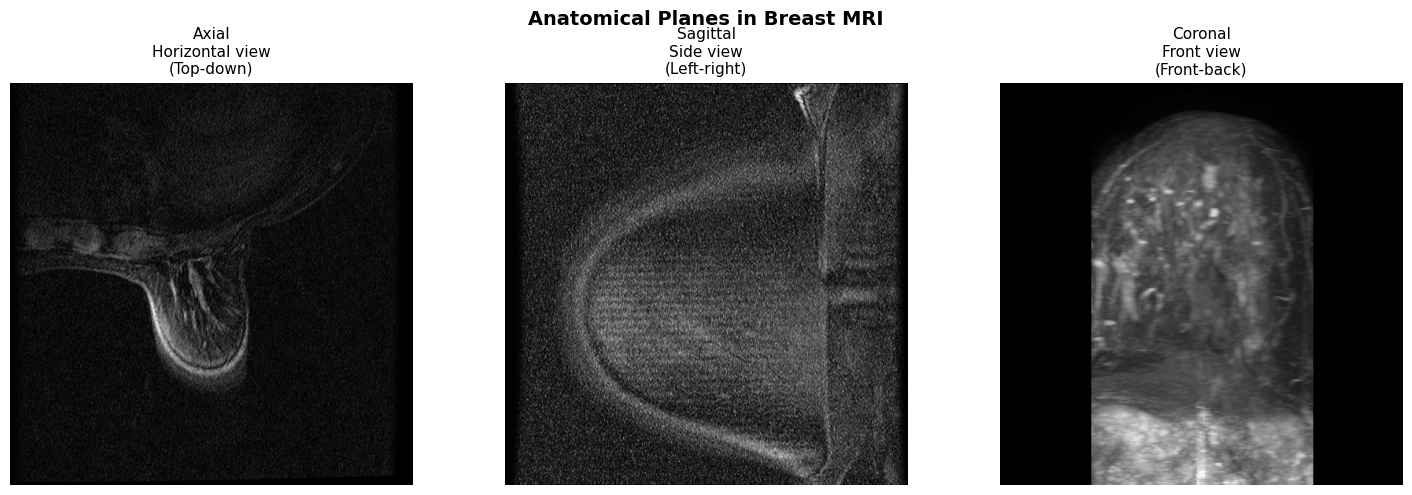

In [ ]:
plane_info = {'Axial': 'Horizontal view\n(Top-down)','Sagittal': 'Side view\n(Left-right)','Coronal': 'Front view\n(Front-back)'}
planes = ['Axial', 'Sagittal', 'Coronal']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Anatomical Planes in Breast MRI', fontsize=14, fontweight='bold')

for idx, plane in enumerate(planes):
    ax = axes[idx]
    plane_data = df[df['Plane'] == plane]
    if len(plane_data) > 0:
        file_path = plane_data.iloc[0]['file_path']

        if os.path.exists(file_path):
            dcm = pydicom.dcmread(file_path)
            img = dcm.pixel_array
            img = (img - img.min()) / (img.max() - img.min())
            ax.imshow(img, cmap='gray')

    ax.axis('off')
    ax.set_title(f'{plane}\n{plane_info[plane]}', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
OUTPUT_FILE = "raw_data.parquet"
df = pd.read_parquet(OUTPUT_FILE)

df['series_image_count'] = df.groupby('series_instance_uid')['instance_number'].transform('count')
df['series_image_count'] = pd.to_numeric(df['series_image_count'], errors='coerce')
df.loc[:, "category"] = "UNKNOW"

In [ ]:
pos_split = df['image_position'].str.split(';', expand=True)
df['patient_x'] = pd.to_numeric(pos_split[0], errors='coerce')
df['patient_y'] = pd.to_numeric(pos_split[1], errors='coerce')
df['patient_z'] = pd.to_numeric(pos_split[2], errors='coerce')

spacing_split = df['Pixel_pacing'].str.split(';', expand=True)
df['pixel_spacing_x'] = pd.to_numeric(spacing_split[0], errors='coerce')
df['pixel_spacing_y'] = pd.to_numeric(spacing_split[1], errors='coerce')

orient_split = df['image_orientation'].str.split(';', expand=True)
df['V_row_x'] = pd.to_numeric(orient_split[0], errors='coerce')
df['V_row_y'] = pd.to_numeric(orient_split[1], errors='coerce')
df['V_row_z'] = pd.to_numeric(orient_split[2], errors='coerce')
df['V_col_x'] = pd.to_numeric(orient_split[3], errors='coerce')
df['V_col_y'] = pd.to_numeric(orient_split[4], errors='coerce')
df['V_col_z'] = pd.to_numeric(orient_split[5], errors='coerce')

df['Columns'] = pd.to_numeric(df['Columns'], errors='coerce')
df['Rows'] = pd.to_numeric(df['Rows'], errors='coerce')

df['vec_width_x'] = (df['Columns'] - 1) * df['pixel_spacing_x'] * df['V_row_x']
df['vec_height_x'] = (df['Rows'] - 1) * df['pixel_spacing_y'] * df['V_col_x']

P_tl_x = df['patient_x']
P_tr_x = df['patient_x'] + df['vec_width_x']
P_bl_x = df['patient_x'] + df['vec_height_x']
P_br_x = df['patient_x'] + df['vec_width_x'] + df['vec_height_x']

df['x_min_slice'] = pd.DataFrame([P_tl_x, P_tr_x, P_bl_x, P_br_x]).min(axis=0)
df['x_max_slice'] = pd.DataFrame([P_tl_x, P_tr_x, P_bl_x, P_br_x]).max(axis=0)

series_stats = df.groupby('series_instance_uid').agg(x_var=('patient_x', 'var'),y_var=('patient_y', 'var'),z_var=('patient_z', 'var'),
    x_min_series=('x_min_slice', 'min'),x_max_series=('x_max_slice', 'max'),V_row_x_first=('V_row_x', 'first')).fillna(0).reset_index()

series_stats['x_center'] = (series_stats['x_min_series'] + series_stats['x_max_series']) / 2

def determine_plane(row):

    nx = row['x_var']
    ny = row['y_var']
    nz = row['z_var']

    dominant = max(nx, ny, nz)

    if dominant == nz:
        return 'Axial'
    elif dominant == ny:
        return 'Coronal'
    elif dominant == nx:
        return 'Sagittal'
    else:
        return 'Oblique'

series_stats['Plane'] = series_stats.apply(determine_plane, axis=1)

def determine_laterality(row):
    plane = row['Plane']
    x_center = row['x_center']

    if plane in ['Axial', 'Coronal']:
        if x_center > 10:
            return 'L'
        elif x_center < -10:
            return 'R'
        else:
            return 'B'
    elif plane == 'Sagittal':
        if x_center > 10:
            return 'L'
        elif x_center < -10:
            return 'R'
        else:
            return 'O'
    else:
        return 'O'

series_stats['Laterality'] = series_stats.apply(determine_laterality, axis=1)
result_df = series_stats[['series_instance_uid', 'Plane', 'x_center', 'Laterality']]

for col in ['Laterality', 'Plane', 'x_center']:
    if col in df.columns:
        df = df.drop(columns=[col])

df = df.merge(result_df, on='series_instance_uid', how='left')

In [ ]:
def normalize_breast(breast_value):

    if pd.isna(breast_value):
        return 'U'

    breast_str = str(breast_value).upper().strip()
    left_patterns = ['L_BREAST', "LEFT BREAST CA", "LT BREAST CA" , "LBREAST", "LEFT BREAST DCIS", "LT BREAST FOR ILC", "LFT BREAST CA"]
    right_patterns = ['R_BREAST', "RIGHT BREAST CA","RT BREAST CA", "RBREAST", "RT BREAS5T CA"]
    bilat_patterns = ["BREAST"]

    is_left = any(pattern in breast_str for pattern in left_patterns)
    is_right = any(pattern in breast_str for pattern in right_patterns)

    if is_left:
        return 'L'
    if is_right:
        return 'R'
    is_bilateral = any(breast_str == pattern for pattern in bilat_patterns)
    if is_bilateral:
        return 'B'
    return 'U'

df["Breast_R_L_normalized"] = df['Breast_R_L'].apply(normalize_breast)

mask = df["Breast_R_L_normalized"] == "U"
df.loc[mask, "Breast_R_L_normalized"] = df.loc[mask, "Laterality"]

Validation: 100%|███████████████████████████| 3982/3982 [01:10<00:00, 56.42it/s]
/tmp/ipykernel_2464/2297136592.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  errors_by_category = comparison_df.groupby('ground_truth').apply(lambda x: (~x['match']).sum())



Accuracy per category:
  - L: 1533/1755 (87.35%)
  - R: 1283/1483 (86.51%)
  - B: 366/744 (49.19%)

CONFUSION MATRIX:
predicted       B     L    O     R   All
ground_truth                            
B             366    94  128   156   744
L              47  1533   30   145  1755
R              38   134   28  1283  1483
All           451  1761  186  1584  3982


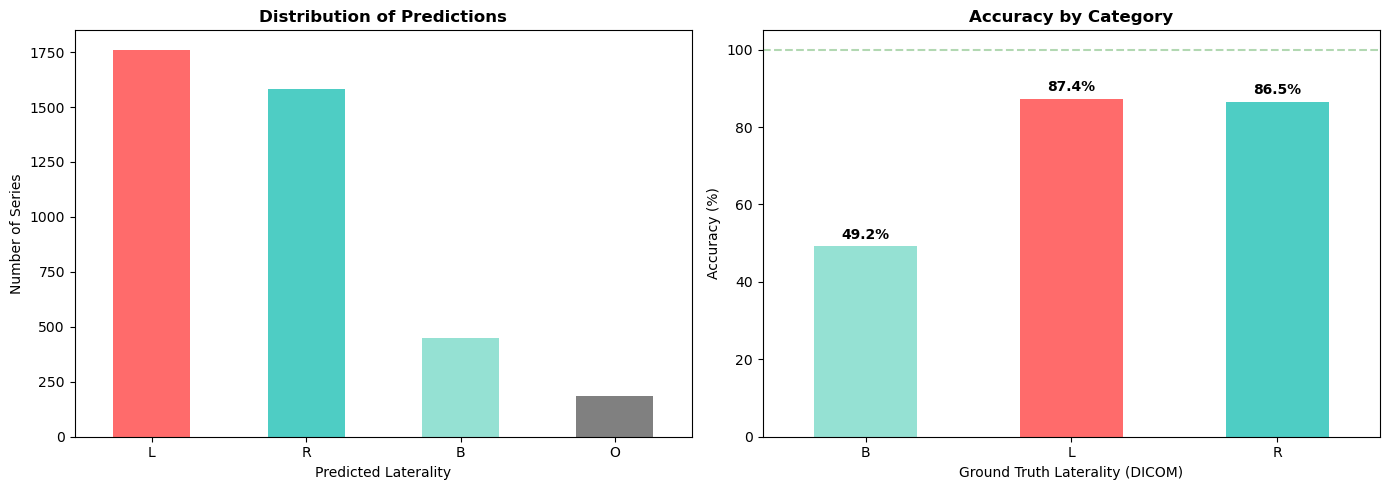

In [ ]:
def validate_laterality_algorithm(df):

    df['Breast_R_L_normalized'] = df['Breast_R_L'].apply(normalize_breast)
    df_known = df[df['Breast_R_L_normalized'].isin(['L', 'R', 'B'])].copy()
    ref_dist = df_known['Breast_R_L_normalized'].value_counts()
    series_comparison = []

    for series_id in tqdm(df_known['series_instance_uid'].unique(), desc="Validation"):
        series_data = df_known[df_known['series_instance_uid'] == series_id]
        ground_truth = series_data['Breast_R_L_normalized'].iloc[0]
        predicted = series_data['Laterality'].iloc[0] if 'Laterality' in series_data.columns else 'B'
        original_dicom = series_data['Breast_R_L'].iloc[0]

        series_comparison.append({'series_instance_uid': series_id,'ground_truth': ground_truth,'predicted': predicted,
            'match': ground_truth == predicted,'original_dicom_value': original_dicom})

    comparison_df = pd.DataFrame(series_comparison)
    if comparison_df.empty:
        return None

    stats = {'total_series_with_reference': len(comparison_df),'correct_predictions': comparison_df['match'].sum(),'incorrect_predictions': (~comparison_df['match']).sum(),'accuracy': comparison_df['match'].mean() * 100,}

    b_series = comparison_df[comparison_df['ground_truth'] == 'B']
    if len(b_series) > 0:
        b_correct = b_series['match'].sum()
        b_total = len(b_series)
        b_accuracy = (b_correct / b_total) * 100
        stats['bilateral_correct'] = b_correct
        stats['bilateral_total'] = b_total
        stats['bilateral_accuracy'] = b_accuracy
    else:
        stats['bilateral_correct'] = 0
        stats['bilateral_total'] = 0
        stats['bilateral_accuracy'] = 0

    confusion = pd.crosstab(comparison_df['ground_truth'], comparison_df['predicted'], margins=True)
    error_analysis = comparison_df[~comparison_df['match']].groupby(['ground_truth', 'predicted']).size()
    errors_by_category = comparison_df.groupby('ground_truth').apply(lambda x: (~x['match']).sum())

    print(f"\nAccuracy per category:")
    accuracy_by_class = comparison_df.groupby('ground_truth')['match'].mean() * 100
    for cat in ['L', 'R', 'B']:
        if cat in accuracy_by_class.index:
            total = len(comparison_df[comparison_df['ground_truth'] == cat])
            correct = comparison_df[(comparison_df['ground_truth'] == cat) & (comparison_df['match'])].shape[0]
            print(f"  - {cat}: {correct}/{total} ({accuracy_by_class[cat]:.2f}%)")
        else:
            print(f"  - {cat}: 0/0 (N/A)")

    print("\nCONFUSION MATRIX:")
    print(confusion)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax1 = axes[0]
    prediction_dist = comparison_df['predicted'].value_counts()
    colors = {'L': '#FF6B6B', 'R': '#4ECDC4', 'B': '#95E1D3'}
    prediction_dist.plot(kind='bar', ax=ax1, color=[colors.get(x, 'gray') for x in prediction_dist.index])
    ax1.set_title('Distribution of Predictions', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Predicted Laterality')
    ax1.set_ylabel('Number of Series')
    ax1.tick_params(axis='x', rotation=0)

    ax2 = axes[1]
    accuracy_by_class = comparison_df.groupby('ground_truth')['match'].mean() * 100
    accuracy_by_class.plot(kind='bar', ax=ax2, color=[colors.get(x, 'gray') for x in accuracy_by_class.index])
    ax2.set_title('Accuracy by Category', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Ground Truth Laterality (DICOM)')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim([0, 105])
    ax2.axhline(y=100, color='green', linestyle='--', alpha=0.3, label='100%')
    ax2.tick_params(axis='x', rotation=0)

    for i, v in enumerate(accuracy_by_class):
        ax2.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return {'stats': stats,'confusion_matrix': confusion,'comparison_df': comparison_df,'error_analysis': error_analysis,'errors_by_category': errors_by_category}

results = validate_laterality_algorithm(df)

## Breast labelling

One key piece of information missing is which breast was analyzed (the left one, the right one, or both). This information is often unavailable. To address this issue, we could check a free-text description that might state this, but as it is free text, the information is missing most of the time.

I have created an algorithm that I tested using information I can trust, and I believe it should produce good results. It is based on geometrical information, as MRI images are standardized so that right corresponds to the negative $x$ axis and left corresponds to the positive $x$ axis.

To determine if the right or left breast was analyzed, I based my logic on the center of the image. If the image center is oriented more in the negative $x$-direction, the breast analyzed is the right one. When the image is centered very near the origin (where $x \approx 0$), I label the case as both breasts.

The poor results for the both breasts category are due to some images being labeled as two breasts but only containing one, which makes the evaluation difficult. Furthermore, a proportion of the images are not fully aligned; they are oblique.

# Plan of mapping

The detection of the DCE of a person can change base on the manufacturer that have taken the MRI since they hve them on ways to store the data in this data we have 6 different manufacturer by only 5 will be processed because the Confirma Inc. manufacturer has only processed iamge and we are iamge to detect the orginal 3D DCE MRI the first thing done was to use the clinical data to find all the patient that has done a dynamic MRI so sametime patient cannot do dynamic RMI for example pregnant woman etc.. to filter this data set I used the clinical data to detect patient that as cinital analysis 375 has been found with one






In [ ]:
def filtrer_dataframe_par_patients_dce(df_a_filtrer, df_source_patients):

    dce_cols = ["m3e13", "m3e14", "m3e15", "m3e67"]
    valid_cols = [col for col in dce_cols if col in df_source_patients.columns]

    has_dce_mask = ((df_source_patients[valid_cols].notna()) & (df_source_patients[valid_cols] != 0)).any(axis=1)
    patients_avec_dce = df_source_patients.loc[has_dce_mask, 'cn'].unique()

    df_filtre = df_a_filtrer[df_a_filtrer['cn'].isin(patients_avec_dce)].copy()

    nombre_patients_filtres = df_filtre['cn'].nunique()
    print(f"The data set contains {nombre_patients_filtres} patients with a DCE.")
    return df_filtre

df['cn'] = df['patient_id'].str.extract(r'(\d+)$')[0].astype(int)
df_MRI = pd.read_csv("ACRIN 6667 Contralateral Breast MRI Clinical Data Anonymized/6667_M3 reviewed.csv")
df_initial_clinical_data = pd.read_csv("ACRIN 6667 Contralateral Breast MRI Clinical Data Anonymized/6667_I1 reviewed.csv")

reduced_DCE_data = filtrer_dataframe_par_patients_dce(df_a_filtrer=df, df_source_patients=df_MRI)

df_initial_clinical_data["i1e34"] = df_initial_clinical_data["i1e34"].replace({2.00 : "L" , 1.0 : "R"})
cancer_dict = df_initial_clinical_data.set_index("cn")["i1e34"].to_dict()

reduced_DCE_data["initial_cancer_location"] = reduced_DCE_data["cn"].replace(cancer_dict)

The data set contains 375 patients with a DCE.


## Manufacturer: Philips Medical Systems

The first manufacturer processed was Philips, which was the easier one. They have tags (like TemporalPositionIdentifier and NumberOfTemporalPositions) which represent the number of temporal positions of the MRI. If there are more than 3, we can consider this series a DCE MRI.

In [ ]:
df_philips = reduced_DCE_data[reduced_DCE_data["Manufacturer"] == "Philips Medical Systems"].copy()
df_philips['NumberOfTemporalPositions']= df_philips['NumberOfTemporalPositions'].astype(int)
df_philips['category'] = df_philips['Laterality'].apply(categorize_breast)
mask_valid_phases = (df_philips['NumberOfTemporalPositions'] > 2) & (df_philips['NumberOfTemporalPositions'] <= 6)
df_philips_dce = df_philips[mask_valid_phases].copy()
nb_patient_DCE= len(df_philips_dce["patient_id"].unique())

print(f"Number of unique patient in the final dataset : {nb_patient_DCE} manufacturer Philips Medical.")


Number of unique patient in the final dataset : 72 manufacturer Philips Medical.


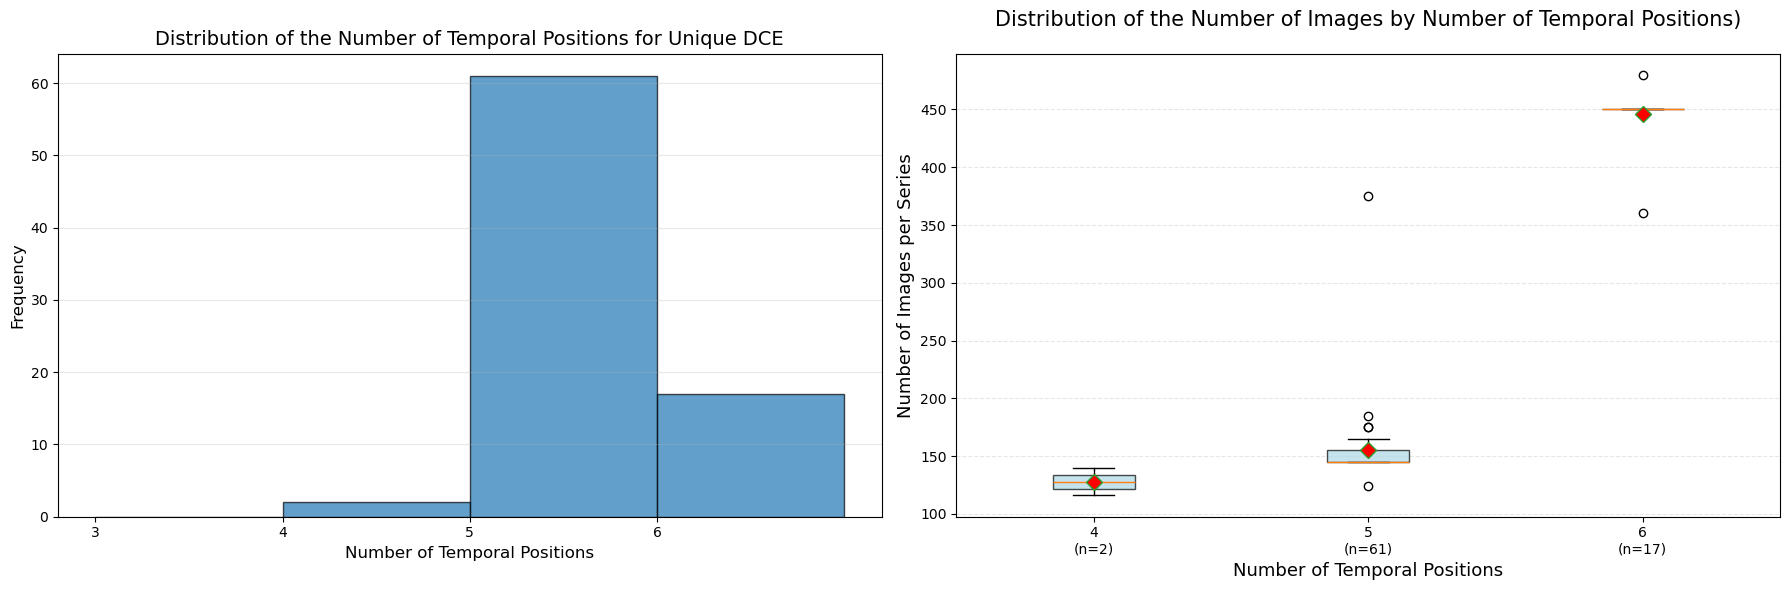

In [ ]:
df_unique_dce = df_philips_dce.drop_duplicates(subset=['patient_id', 'category'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.hist(df_unique_dce['NumberOfTemporalPositions'], bins=range(3, 8),edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of Temporal Positions', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of the Number of Temporal Positions for Unique DCE', fontsize=14)
ax1.set_xticks(range(3, 7))
ax1.grid(axis='y', alpha=0.3)

categories = sorted(df_unique_dce['NumberOfTemporalPositions'].unique())
data_to_plot = [df_unique_dce[df_unique_dce['NumberOfTemporalPositions'] == cat]['series_image_count'].values
                for cat in categories]
bp = ax2.boxplot(data_to_plot, labels=categories,patch_artist=True,showmeans=True,
                  meanprops=dict(marker='D', markerfacecolor='red', markersize=8, label='Mean'))

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax2.set_xlabel('Number of Temporal Positions', fontsize=13)
ax2.set_ylabel('Number of Images per Series', fontsize=13)
ax2.set_title('Distribution of the Number of Images by Number of Temporal Positions)',
              fontsize=15, pad=20)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

x_labels = [f'{cat}\n(n={len(df_unique_dce[df_unique_dce["NumberOfTemporalPositions"] == cat])})'
            for cat in categories]
ax2.set_xticklabels(x_labels)

plt.tight_layout()
plt.show()

This was the easier Manufacturer to map due to they have a really good data sturture hoevoer the next one "GE MEDICAL SYSTEMS" but does not has tag like temporal position of temporal identifes as philips but they has an instructing tag iamge in aqusition to often refer to the number of image in temporal positon but I also find pattenr inthe description written by the medcin some of they respect a format

## Manufacturer: GE MEDICAL SYSTEMS

However, there are a lot of aberrant values for the number of temporal positions. I believe this is because doctors have different protocols, but as I am not a medic, I decided to only keep those with 3 to 7 temporal positions, as I found on the internet that this is generally a standard.

This was the easiest manufacturer to map because they have a really good data structure. However, the next one GE MEDICAL SYSTEMS does not have tags like Temporal Position or Temporal Identifiers as Philips does.

Instead, they have an interesting tag that seems to refer to the number of images in a temporal position. I also found patterns in the description written by the doctor, as some of them follow a specific format.

## POST & PRE

Nonetheless, in the free-text section, we can find information about the acquisition. The series description provides information on the nature of the images, and I found some patterns in this section that I used to identify DCEs.

The first format I look for is 'PRE' & 'POST'. When these two are grouped in a series study, it often refers to the pre-contrast acquisition (taken before the contrast agent is injected) and the post-contrast acquisition (taken after the contrast has been injected into the region of interest) inside the same series.

I also use the number of images in one acquisition as a test to verify if it is a DCE. For example, if a series has 'post' and 'pre' in its description and the number of images in one acquisition is 60, we should expect a total number of images of 180. This refers to 3 temporal positions, which is the minimum for a DCE.

In [ ]:
df_GE_SIG = df[df["Manufacturer"] == "GE MEDICAL SYSTEMS"]

mask_1 = df_GE_SIG['series_description'].str.contains(r'(?=.*\bpre\b)(?=.*\bpost\b)', case=False, na=False, regex=True)
mask_2 = df_GE_SIG['series_description'].str.contains(r'(?=.*\bpre\b)(?=.*post)', case=False, na=False, regex=True)
mask_full_dce = mask_1 | mask_2
df_GE_both = df_GE_SIG[mask_full_dce].copy()

idx = df_GE_both.groupby(['study_instance_uid', 'manufacturer_model', 'Laterality','series_description'])['series_image_count'].idxmax()

best_series = df_GE_both.loc[idx, ['study_instance_uid', 'series_instance_uid','manufacturer_model','Laterality','series_description']]

df_GE_both_f = df_GE_both.merge(best_series, on=['study_instance_uid', 'series_instance_uid','manufacturer_model','Laterality','series_description'], how='inner')

df_GE_both_f['category'] = df_GE_both_f['Laterality'].apply(categorize_breast)
dce_dict = df_GE_both_f.groupby('patient_id')['study_instance_uid'].nunique().to_dict()

df_GE_both_f["Nb_image_in_one_serie_GE"] = df_GE_both_f["Nb_image_in_one_serie_GE"].astype(int)
df_GE_both_f["ratio"] = df_GE_both_f["series_image_count"] / df_GE_both_f["Nb_image_in_one_serie_GE"]

mask_is_integer = (df_GE_both_f["ratio"] % 1) == 0
mask_greater_equal_3 = df_GE_both_f["ratio"] >= 3
mask_keep = mask_is_integer & mask_greater_equal_3

df_GE_both_f_final = df_GE_both_f[mask_keep].copy()

excluded_patients = df_GE_both_f.loc[~mask_keep, "patient_id"].unique()
dce_study_uids = df_GE_both_f_final['study_instance_uid'].unique().tolist()
df_cleaned = df_GE_SIG[~df_GE_SIG['study_instance_uid'].isin(dce_study_uids)].copy()

nb_patient_DCE= len(df_GE_both_f_final["patient_id"].unique())
print(f"Number of unique patient in the final dataset : {nb_patient_DCE} manufacturer GE medical." )

Number of unique patient in the final dataset : 94 manufacturer GE medical.


Some of the images do not respect the rule. After reviewing them, I realized I don't have the medical background to perform such labeling. I therefore decided to exclude the images that do not respect this rule of a minimum of 3 to 7. I withdrew them, as there were many, and I don't have the qualification to assess them.

## Second: POST & PRE

In some descriptions, we have PRE in one series and several POST series description. The method is the following:

We detect all the series with PRE or POST. We only process studies with one PRE series and several POST series. To verify if it is a DCE, we verify that these data have a ratio superior to 3. To also catch the information when there are 2 DCEs in a single study (for example, one on the left and the other one on the right), I group the data by the breast detected by my previous algorithm.

## Third: Dyn or Dynamics

Some descriptions contain dynamic or dyn which indicates a dynamic acquisition, which means it is a DCE. I use this last pattern to find the remaining DCEs.

In [ ]:
def process_series(df_input, series_type, ratio_filter_func, include_pre_post=False):

    df = df_input[df_input["Nb_image_in_one_serie_GE"].notna()].copy()
    df["Nb_image_in_one_serie_GE"] = pd.to_numeric(df["Nb_image_in_one_serie_GE"], errors='coerce')
    df = df[df["Nb_image_in_one_serie_GE"] > 0].copy()

    df_unique = df.drop_duplicates(subset=['series_instance_uid'], keep='first').copy()
    df_unique['category'] = df_unique['Laterality'].apply(categorize_breast)

    if include_pre_post:
        df_unique['is_pre'] = df_unique['series_description'].str.contains(r'\bpre\b', case=False, na=False)
        df_unique['is_post'] = df_unique['series_description'].str.contains(r'\bpost\b', case=False, na=False)
        df_unique = df_unique[df_unique['is_pre'] | df_unique['is_post']].copy()

    agg_dict = {'series_image_count': 'sum','patient_id': 'first','category': 'first','series_instance_uid': 'count'}

    if include_pre_post:
        agg_dict['is_pre'] = 'any'
        agg_dict['is_post'] = 'any'

    df_agg = df_unique.groupby(['study_instance_uid', 'manufacturer_model', 'Nb_image_in_one_serie_GE', 'Laterality'], as_index=False).agg(agg_dict)

    df_agg = df_agg.rename(columns={'series_instance_uid': 'nb_series_in_group'})

    if include_pre_post:
        df_agg = df_agg[df_agg['is_pre'] & df_agg['is_post']].copy()

    df_agg["ratio"] = df_agg["series_image_count"] / df_agg["Nb_image_in_one_serie_GE"]

    mask_non_integer = (df_agg["ratio"] % 1) != 0
    mask_excluded_low, mask_excluded_high, mask_accepted = ratio_filter_func(df_agg, mask_non_integer)

    df_agg_filtered = df_agg[mask_accepted].copy()

    df_with_ratio = df_unique.merge(df_agg_filtered[['study_instance_uid', 'manufacturer_model', 'Nb_image_in_one_serie_GE', 'Laterality', 'ratio']],
                                    on=['study_instance_uid', 'manufacturer_model', 'Nb_image_in_one_serie_GE', 'Laterality'],how='inner')

    valid_series = df_with_ratio['series_instance_uid'].unique()
    df_final = df_input[df_input['series_instance_uid'].isin(valid_series)].copy()

    df_final = df_final.merge(df_with_ratio[['series_instance_uid', 'ratio', 'category']].drop_duplicates(),on='series_instance_uid',how='inner')
    return df_final, df_agg_filtered

mask_pre = df_cleaned['series_description'].str.contains(r'\bpre\b', case=False, na=False)
mask_post = df_cleaned['series_description'].str.contains(r'\bpost\b', case=False, na=False)

df_pre = df_cleaned[mask_pre].copy()
df_post = df_cleaned[mask_post].copy()

pre_studies = set(df_pre['study_instance_uid'])
post_studies = set(df_post['study_instance_uid'])
common_studies = pre_studies.intersection(post_studies)

df_dce = df_cleaned[df_cleaned['study_instance_uid'].isin(common_studies)].copy()

def dce_ratio_filter(df_agg, mask_non_integer):
    mask_excluded_low = (df_agg["ratio"] < 3) & (~mask_non_integer)
    mask_excluded_high = df_agg["ratio"] > 6

    mask_accepted = (df_agg["ratio"] >= 3) & (df_agg["ratio"] <= 6)

    return mask_excluded_low, mask_excluded_high, mask_accepted

df_dce_final, df_dce_agg = process_series(df_dce, 'DCE', dce_ratio_filter, include_pre_post=True)

dce_study_uids = df_dce_final['study_instance_uid'].unique().tolist()
df_non_dce = df_cleaned[~df_cleaned['study_instance_uid'].isin(dce_study_uids)].copy()

mask_dyn = df_non_dce['series_description'].str.contains('dyn|dynamic', case=False, na=False)
df_dyn = df_non_dce[mask_dyn].copy()

def dynamic_ratio_filter(df_agg, mask_non_integer):
    mask_single_ratio1 = (df_agg["nb_series_in_group"] == 1) & (df_agg["ratio"] == 1)

    if mask_single_ratio1.any():
        patients_single = df_agg.loc[mask_single_ratio1, "patient_id"].unique()
    mask_excluded_low = (df_agg["ratio"] < 3) & (~mask_non_integer) & (~mask_single_ratio1)
    mask_excluded_high = df_agg["ratio"] > 6
    mask_accepted = ((df_agg["ratio"] >= 3) & (df_agg["ratio"] <= 6)) | mask_single_ratio1

    return mask_excluded_low, mask_excluded_high, mask_accepted

df_dyn_final, df_dyn_agg = process_series(df_dyn, 'DYNAMIC', dynamic_ratio_filter, include_pre_post=False)

multi_config = df_dyn_final.groupby('patient_id').agg({'manufacturer_model': lambda x: list(x.unique()),'Laterality':
                                                       lambda x: list(x.unique()),'study_instance_uid': 'nunique'}).reset_index()
multi_config['nb_configs'] = multi_config.apply(lambda row: len(row['manufacturer_model']) * len(row['Laterality']), axis=1)
multi_config_filtered = multi_config[multi_config['nb_configs'] > 1]
dyn_study_uids = df_dyn_final['study_instance_uid'].unique().tolist()
df_non_dce = df_non_dce[~df_non_dce['study_instance_uid'].isin(dyn_study_uids)].copy()

nb_patient_DCE= len(df_dyn_final["patient_id"].unique())
print(f"Number of unique patient in the final dataset : {nb_patient_DCE} manufacturer GE medical." )

Number of unique patient in the final dataset : 25 manufacturer GE medical.


In [ ]:
df_combined = pd.concat([df_dce_final, df_dyn_final], ignore_index=True)
df_combined = df_combined[df_combined["ratio"] >= 3]
df_combined["ratio"] =df_combined["ratio"].astype(int)
df_combined['category'] = df_combined['category_x'].fillna(df_combined['category_y'])
df_combined = df_combined.drop(columns=['category_x', 'category_y'])

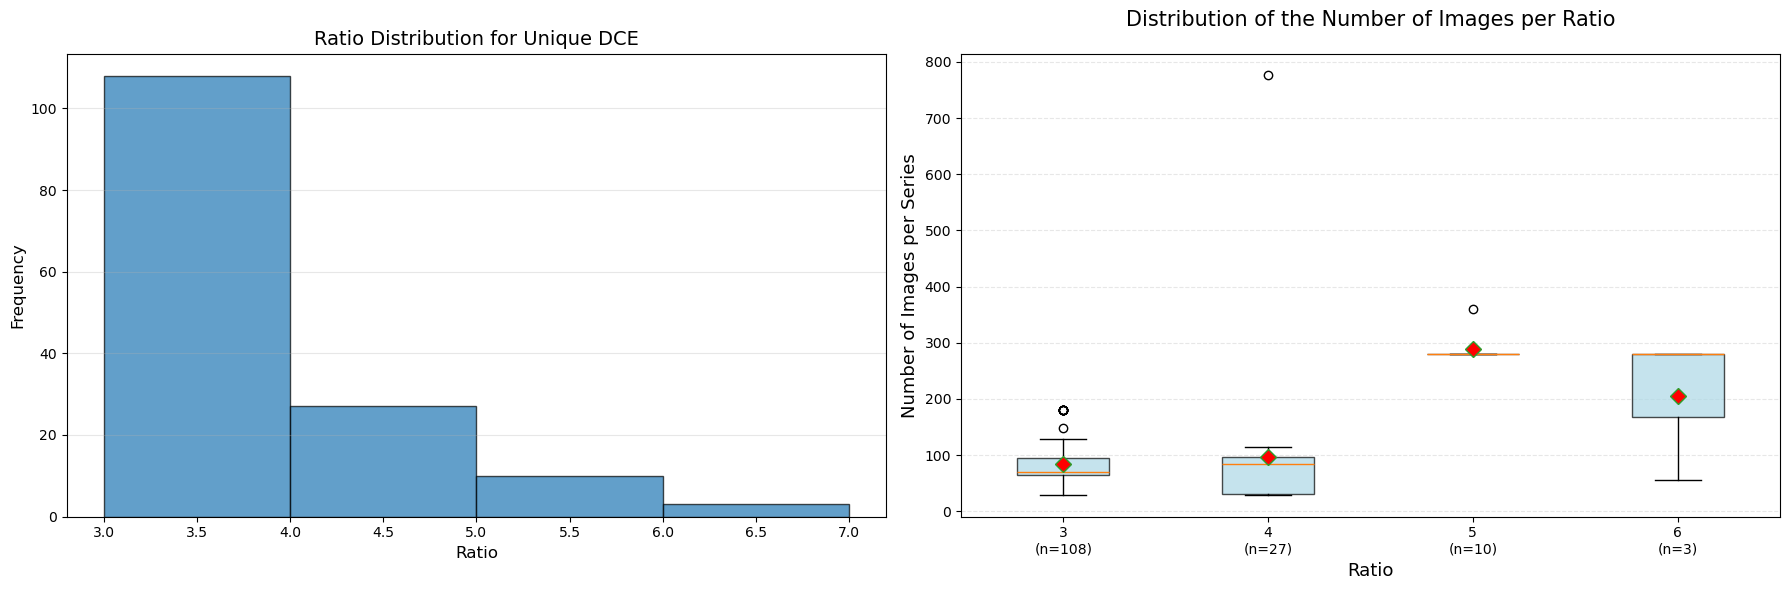

In [ ]:
df_unique_dce_ge = df_combined.drop_duplicates(subset=['patient_id', 'category'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.hist(df_unique_dce_ge['ratio'], bins=range(int(df_unique_dce_ge['ratio'].min()), int(df_unique_dce_ge['ratio'].max()) + 2),edgecolor='black', alpha=0.7)

ax1.set_xlabel('Ratio', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Ratio Distribution for Unique DCE', fontsize=14)
ax1.grid(axis='y', alpha=0.3)

categories = sorted(df_unique_dce_ge['ratio'].unique())
data_to_plot = [df_unique_dce_ge[df_unique_dce_ge['ratio'] == cat]['series_image_count'].values
                for cat in categories]
bp = ax2.boxplot(data_to_plot, labels=categories,patch_artist=True,showmeans=True,meanprops=dict(marker='D', markerfacecolor='red', markersize=8, label='Moyenne'))

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax2.set_xlabel('Ratio', fontsize=13)
ax2.set_ylabel('Number of Images per Series', fontsize=13)
ax2.set_title('Distribution of the Number of Images per Ratio',
              fontsize=15, pad=20)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

x_labels = [f'{cat:.0f}\n(n={len(df_unique_dce_ge[df_unique_dce_ge["ratio"] == cat])})' for cat in categories]
ax2.set_xticklabels(x_labels)

plt.tight_layout()
plt.show()

## Concluding the Labeling Process

Even though I tried, I have been unable to find trustworthy patterns for the rest of the manufacturers or for the remaining unmapped GE data.

Therefore, I used an LLM to detect the DCEs. I decided to use a temperature of 0 so the model would be deterministic ensuring the reproducibility of the pipeline. However, I got my Google account canceled because I used the word "Breast" I tried to appeal this, but I haven't received any response yet.

Because of this, I could not try other prompts. Even though the first few were a great start, there are some errors that the LLM is making that could be resolved with a few corrections in the prompt.

In [ ]:
df_siemens_upper = reduced_DCE_data[reduced_DCE_data["Manufacturer"] == 'SIEMENS'].copy()
df_canon = reduced_DCE_data[reduced_DCE_data["Manufacturer"] == "Canon Medical Systems"].copy()
df_siemens_lower = reduced_DCE_data[reduced_DCE_data["Manufacturer"] == "Siemens"].copy()

df_concatenated = pd.concat([df_non_dce,df_siemens_upper,df_canon,df_siemens_lower], ignore_index=True)
df_concatenated = df_concatenated.drop_duplicates(subset=['series_instance_uid', 'instance_number'], keep='first').copy()


In [ ]:
df_remain = process_dataset_in_batches(df_concatenated, batch_size=10, api_key=API_GEMINI,system_prompt = SYSTEM_PROMPT)
df_remain.to_parquet("LLM_clasifcation.parquet")

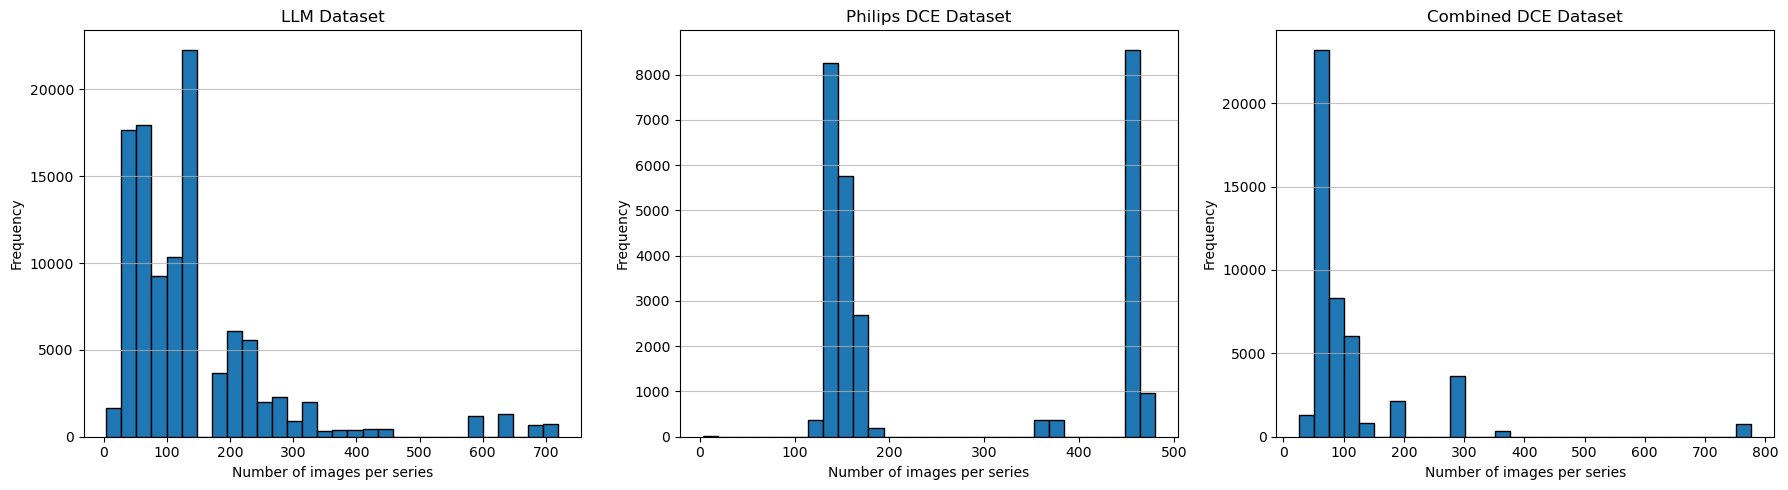

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df_remain["series_image_count"], bins=30, edgecolor='black')
axes[0].set_xlabel('Number of images per series')
axes[0].set_ylabel('Frequency')
axes[0].set_title('LLM Dataset')
axes[0].grid(axis='y', alpha=0.75)

axes[1].hist(df_philips_dce["series_image_count"], bins=30, edgecolor='black')
axes[1].set_xlabel('Number of images per series')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Philips DCE Dataset')
axes[1].grid(axis='y', alpha=0.75)

axes[2].hist(df_combined["series_image_count"], bins=30, edgecolor='black')
axes[2].set_xlabel('Number of images per series')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Combined DCE Dataset')
axes[2].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

In [ ]:
df_combined = pd.concat([df_combined, df_philips_dce], ignore_index=True)
df_combined.to_parquet("final_dce.parquet")

In [ ]:
df = pd.read_parquet("final_dce.parquet")

## Geometrical Normalization

An important process with this data is that all the images are in an **Anisotropic Space**, and I have to transform them into an **Isotropic Space**. But what are anisotropic and isotropic space?

### Isotropic Space

An isotropic image has voxels that are perfect cubes.

This means the spacing, or distance, between the center of one voxel and the next is exactly the same in all three dimensions (x, y, and z).

* **Example:** A voxel might be $1 \text{ mm} \times 1 \text{ mm} \times 1 \text{ mm}$.
* **Analogy:** Think of building a model out of perfect, tiny sugar cubes.
* **Advantage:** This is the ideal for true 3D analysis and reformatting. You can slice the image from any angle and the image quality remains consistent without any distortion.

### Anisotropic Space

An anisotropic image has voxels that are rectangular cuboids.

This means the spacing is different in at least one dimension. Most commonly in medical imaging, the spacing within a slice (x and y) is small, but the distance between the slices (z) is larger.

* **Example:** A voxel might be $1 \text{ mm} \times 1 \text{ mm} \times 3 \text{ mm}$. This is common when a scanner takes high-resolution slices that are 3 mm apart.
* **Analogy:** Think of building a model by stacking thin, rectangular bricks.
* **Disadvantage:** While the image looks good from the original direction it was scanned, if you try to reconstruct it from the side (a "sagittal" view), the image will look blocky, smeared, or distorted because the information in the z-direction is less detailed.

The **reason why** most of the images are in this shape is for **reasons** of **practicality and patient comfort**. During the MRI, we can only **scan** the person for a **certain** amount of time for safety.

But most machine learning methods assume that the 3D volume is isotropic, which is why I have to normalize the data.

In [ ]:
df["slice_thickness"] = pd.to_numeric(df["slice_thickness"], errors='coerce')
df[["slice_thickness" , "pixel_spacing_x" , "pixel_spacing_y"]].describe()

,slice_thickness,pixel_spacing_x,pixel_spacing_y
count,74143.000000,74143.000000,74143.000000
mean,3.052501,0.698418,0.698418
std,0.454339,0.153467,0.153467
min,1.200000,0.351562,0.351562
25%,3.000000,0.683594,0.683594
50%,3.000000,0.781250,0.781250
75%,3.000000,0.781250,0.781250
max,5.000000,1.093750,1.093750


To perform this geometric transformation, I decided to use cubic spline interpolation. This is an interpolation method that avoids artifacts (like overshooting or halos) found in other methods. This way, the medical signal of the images is kept intact, which is really important.

I have implemented several different types of interpolation:
* Order 0: Nearest neighbor
* Order 3: Cubic spline interpolation
* Order 5: Order 5 interpolation

Even though order five is a higher order than cubic, it can  introduce some artifacts. To better visualize this, one could use a Fourier spectrum to see the unusual frequencies.

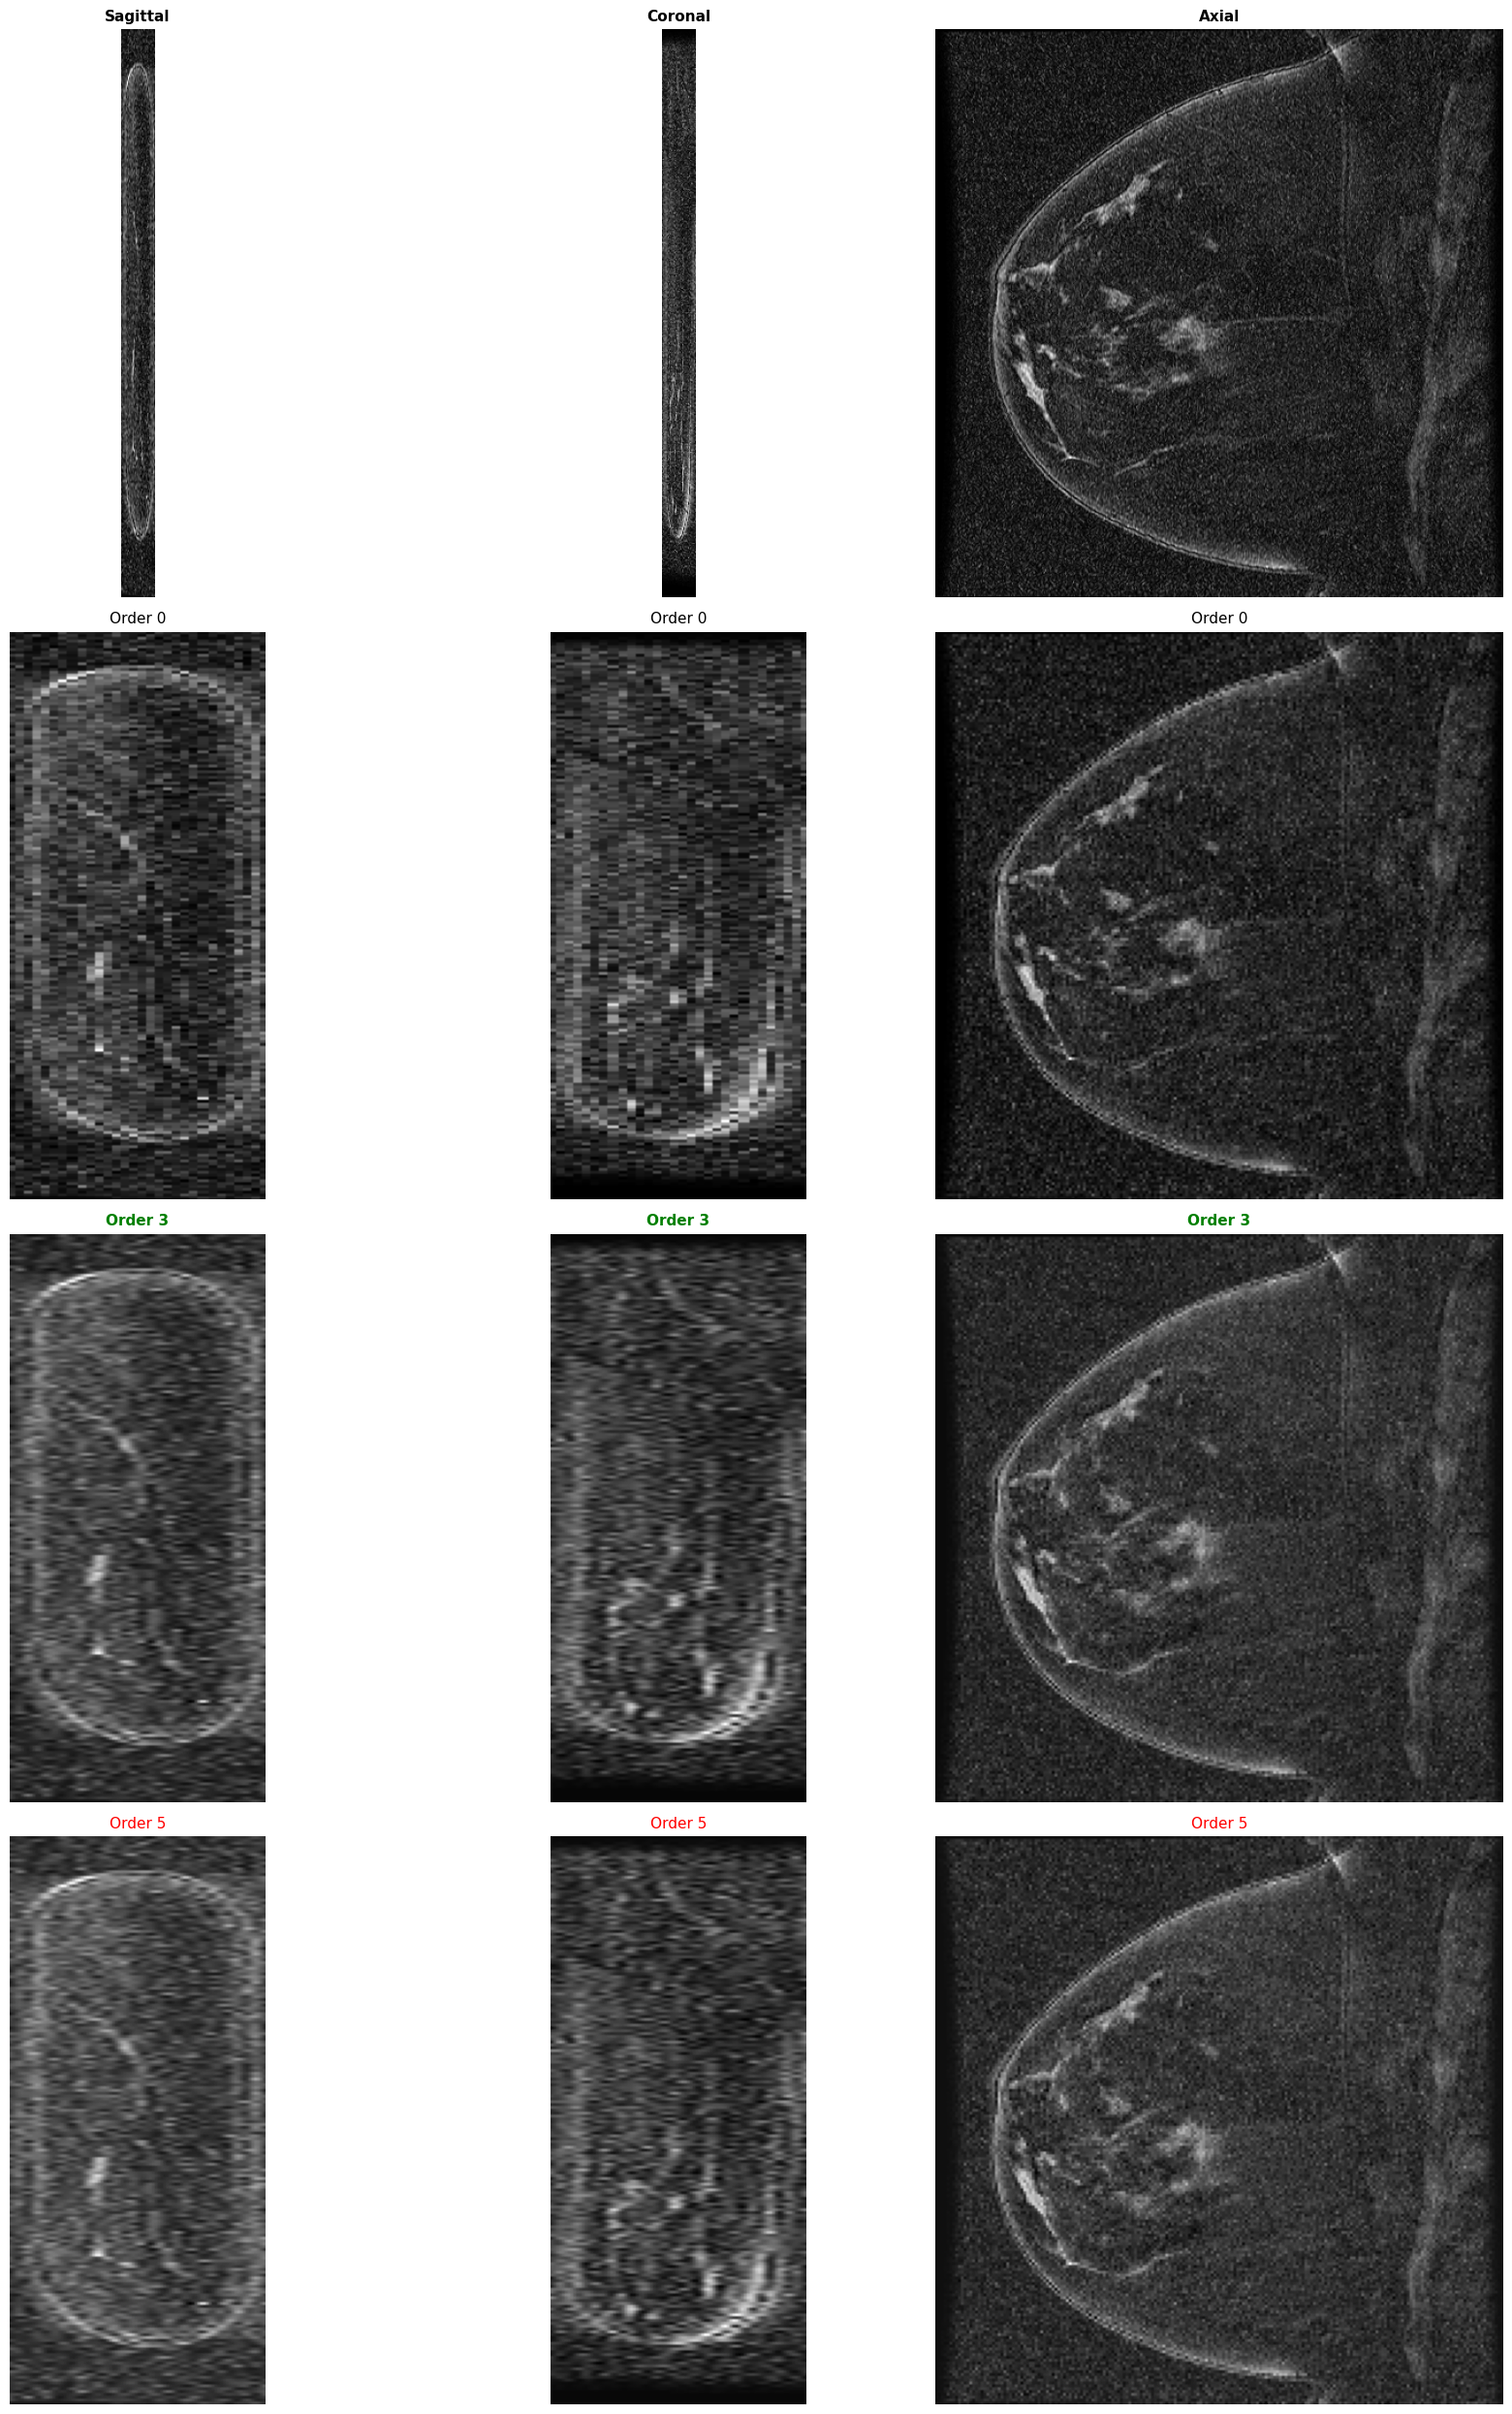

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.ndimage import zoom

def load_volume_and_extract_views(df, series_instance_uid, normalize_to_isotropic=False, interpolation_order=3):

    series_files = df[df['series_instance_uid'] == series_instance_uid].copy()
    series_files = series_files.sort_values('file_path')

    slices = []
    for file_path in series_files['file_path']:
        dcm = pydicom.dcmread(file_path)
        slices.append(dcm.pixel_array)

    volume = np.stack(slices, axis=0)

    dcm = pydicom.dcmread(series_files['file_path'].iloc[0])
    pixel_spacing = dcm.PixelSpacing
    slice_thickness = dcm.SliceThickness if hasattr(dcm, 'SliceThickness') else 3.0

    spacing = [slice_thickness, pixel_spacing[0], pixel_spacing[1]]

    if normalize_to_isotropic:
        zoom_factors = [spacing[0] / 1.0, spacing[1] / 1.0, spacing[2] / 1.0]
        volume = zoom(volume, zoom_factors, order=interpolation_order, mode='nearest')
        spacing = [1.0, 1.0, 1.0]

    mid_slice = volume.shape[0] // 2
    mid_height = volume.shape[1] // 2
    mid_width = volume.shape[2] // 2

    sagittal = volume[:, :, mid_width]
    coronal = volume[:, mid_height, :]
    axial = volume[mid_slice, :, :]

    return sagittal, coronal, axial, volume, spacing

sample_series = df_combined['series_instance_uid'].iloc[0]

sagittal_orig, coronal_orig, axial_orig, volume_orig, spacing_orig = load_volume_and_extract_views(df_combined, sample_series, normalize_to_isotropic=False)
sagittal_o0, coronal_o0, axial_o0, volume_o0, spacing_o0 = load_volume_and_extract_views(df_combined, sample_series, normalize_to_isotropic=True, interpolation_order=0)
sagittal_o3, coronal_o3, axial_o3, volume_o3, spacing_o3 = load_volume_and_extract_views(df_combined, sample_series, normalize_to_isotropic=True, interpolation_order=3)
sagittal_o5, coronal_o5, axial_o5, volume_o5, spacing_o5 = load_volume_and_extract_views(df_combined, sample_series, normalize_to_isotropic=True, interpolation_order=5)

fig, axes = plt.subplots(4, 3, figsize=(18, 25))


axes[0, 0].imshow(sagittal_orig.T, cmap='gray', origin='lower')
axes[0, 0].set_title('Sagittal', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(coronal_orig.T, cmap='gray', origin='lower')
axes[0, 1].set_title('Coronal', fontsize=11, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(axial_orig, cmap='gray')
axes[0, 2].set_title('Axial', fontsize=11, fontweight='bold')
axes[0, 2].axis('off')

axes[1, 0].imshow(sagittal_o0.T, cmap='gray', origin='lower')
axes[1, 0].set_title('Order 0', fontsize=11)
axes[1, 0].axis('off')

axes[1, 1].imshow(coronal_o0.T, cmap='gray', origin='lower')
axes[1, 1].set_title('Order 0', fontsize=11)
axes[1, 1].axis('off')

axes[1, 2].imshow(axial_o0, cmap='gray')
axes[1, 2].set_title('Order 0', fontsize=11)
axes[1, 2].axis('off')

axes[2, 0].imshow(sagittal_o3.T, cmap='gray', origin='lower')
axes[2, 0].set_title('Order 3', fontsize=11, color='green', fontweight='bold')
axes[2, 0].axis('off')

axes[2, 1].imshow(coronal_o3.T, cmap='gray', origin='lower')
axes[2, 1].set_title('Order 3', fontsize=11, color='green', fontweight='bold')
axes[2, 1].axis('off')

axes[2, 2].imshow(axial_o3, cmap='gray')
axes[2, 2].set_title('Order 3', fontsize=11, color='green', fontweight='bold')
axes[2, 2].axis('off')

axes[3, 0].imshow(sagittal_o5.T, cmap='gray', origin='lower')
axes[3, 0].set_title('Order 5', fontsize=11, color='red')
axes[3, 0].axis('off')

axes[3, 1].imshow(coronal_o5.T, cmap='gray', origin='lower')
axes[3, 1].set_title('Order 5', fontsize=11, color='red')
axes[3, 1].axis('off')

axes[3, 2].imshow(axial_o5, cmap='gray')
axes[3, 2].set_title('Order 5', fontsize=11, color='red')
axes[3, 2].axis('off')

plt.tight_layout()
plt.show()